In [ ]:
!pip install numpy matplotlib numba seaborn pandas networkx scipy joblib openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import njit, prange
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.ticker as ticker
from scipy.stats import ks_2samp
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Conduction failure

In [ ]:
# Parameters
dt = 0.1
N = 100 #No. of neurons
T = 120000 #Time
t_IP_on = 0
t_IP_off = 60000
t_myelin_on = t_IP_off + 1000
t_myelin_off = T
time = np.arange(0, T, 1)

beta = 20
epsilon_h = 0.01
h = 1
Ie = 0 #-0.6 #-0.6 + h
Ii = 0 #-0.8 + h
alpha_e = 1
alpha_i = 2
rho = 0.0
D = 0.025
k = 2  # Must remain 2!
theta = 0.05 #4

ce = 0.5
ci = 0.5

kappa = 12
p_ee = 0.11
p_ie = 0.29
p_ei = 0.2
p_ii = 0.26
wee, wie, wei, wii = (0.1825 / p_ee * kappa) / N, (-0.2809 / p_ie * kappa) / N, (0.3508 / p_ei * kappa) / N, (-0.2278 / p_ii * kappa) / N #Campagnola weights

@njit
def F(u, h):
    return 0.5 * (1 + math.erf(beta * (u - h)))

@njit(parallel=True)
def simulate_neurons(v_e, v_i, X, Y, X_cond, Y_cond, W, taue, taui, xie, xii, xi_c, fail_rate_e, fail_rate_i, h_e, h_i, r_e, r_i, epsilon_h, t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, Noise_amplitudes, rng_spike, rng_fail):
  mean_v_e = np.zeros(len(time))
  mean_v_i = np.zeros(len(time))
  spike_count_e = np.zeros(N)
  spike_count_i = np.zeros(N)
  FR_e = np.zeros(N)
  FR_i = np.zeros(N)

  for t in range(len(time) - 1):
    for i in range(N):
      sumee, sumie, sumei, sumii = 0.0, 0.0, 0.0, 0.0
      for j in range(N):
        delay_e, delay_i = max(0, t - taue[i, j]), max(0, t - taui[i, j])
        sumee += wee * X_cond[j, delay_e] * W[i, j]
        sumie += wie * Y_cond[j, delay_i] * W[i, j + N]
        sumei += wei * X_cond[j, delay_e] * W[i + N, j]
        sumii += wii * Y_cond[j, delay_i] * W[i + N, j + N]

      v_e[i, t + 1] = v_e[i, t] + dt * alpha_e * (-v_e[i, t] + sumee + sumie + Ie) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xie[i, t]
      v_i[i, t + 1] = v_i[i, t] + dt * alpha_i * (-v_i[i, t] + sumei + sumii + Ii) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xii[i, t]

      # Adaptive threshold
      if t_IP_on < time[t] < t_IP_off:
        h_e[i, t + 1] = h_e[i, t] + dt * (epsilon_h * (F(v_e[i, t], h_e[i, t]) - r_e[i]))
        h_i[i, t + 1] = h_i[i, t] + dt * (epsilon_h * (F(v_i[i, t], h_i[i, t]) - r_i[i]))
      else:
        h_e[i, t + 1] = h_e[i, t]
        h_i[i, t + 1] = h_i[i, t]

      # Spike generation E
      if rng_spike.random() < (1 - math.exp(-F(v_e[i, t + 1], h_e[i, t + 1]) * dt)):
        X[i, t + 1] = 1 / dt
        if time[t] > t_myelin_on:
          spike_count_e[i] += 1
          if rng_fail.random() > fail_rate_e:
            X_cond[i, t + 1] = 1 / dt
          else:
            X_cond[i, t + 1] = 0
        else:
          X_cond[i, t + 1] = 1 / dt

      # Spike generation I
      if rng_spike.random() < (1 - math.exp(-F(v_i[i, t + 1], h_i[i, t + 1]) * dt)):
          Y[i, t + 1] = 1 / dt
          if time[t] > t_myelin_on:
            spike_count_i[i] += 1
            if rng_fail.random() > fail_rate_i:
              Y_cond[i, t + 1] = 1 / dt
            else:
              Y_cond[i, t + 1] = 0
          else:
              Y_cond[i, t + 1] = 1 / dt

    mean_v_e[t] = np.mean(v_e[:, t])
    mean_v_i[t] = np.mean(v_i[:, t])

  FR_e = spike_count_e / ((T-t_myelin_on) / 1000)
  FR_i = spike_count_i / ((T-t_myelin_on) / 1000)

  return mean_v_e, mean_v_i, FR_e, FR_i, h_e, h_i, X_cond, Y_cond

num_trials = 10
fail_rate_e = [0,0.1]
fail_rate_i = [0,0.3]

def run_trial(num_trials, fail_rate_e, fail_rate_i, r_e, r_i):
  results = {0: [], 1: []}

  for i, (fe, fi) in enumerate(zip(fail_rate_e, fail_rate_i)):
    for trial in range(num_trials):

      L = np.random.gamma(k, theta, size=(N, N))
      taue = np.ceil(L / ce).astype(int)
      taui = np.ceil(L / ci).astype(int)

      W = np.zeros((2*N, 2*N))
      W[0:N, 0:N] = (np.random.rand(N, N) < p_ee).astype(float) # E → E: (pre: 0:N, post: 0:N)
      W[N:2*N, 0:N] = (np.random.rand(N, N) < p_ei).astype(float) # E → I: (post: N:2N, pre: 0:N)
      W[0:N, N:2*N] = (np.random.rand(N, N) < p_ie).astype(float) # I → E: (post: 0:N, pre: N:2N)
      W[N:2*N, N:2*N] = (np.random.rand(N, N) < p_ii).astype(float) # I → I: (post: N:2N, pre: N:2N)
      np.fill_diagonal(W, 0)

      xie = np.random.normal(0, 1, size=(N, len(time)))
      xii = np.random.normal(0, 1, size=(N, len(time)))
      xi_c = np.random.normal(0, 1, size=len(time))
      Noise_amplitudes = np.mean(np.random.uniform(size=N)) * np.ones(N)

      v_e = np.zeros((N, len(time)))
      v_i = np.zeros((N, len(time)))
      X = np.zeros((N, len(time)))
      Y = np.zeros((N, len(time)))
      X_cond = np.zeros((N, len(time)))
      Y_cond = np.zeros((N, len(time)))
      h_e = np.ones((N, len(time))) * h
      h_i = np.ones((N, len(time))) * h

      rng_spike = np.random.default_rng(123 + trial)
      rng_fail = np.random.default_rng(456 + trial)

      mean_v_e, mean_v_i, FR_e, FR_i, h_e_final, h_i_final, X_cond_final, Y_cond_final = simulate_neurons(v_e, v_i, X, Y, X_cond, Y_cond, W, taue, taui, xie, xii, xi_c, fe, fi, h_e, h_i, r_e, r_i, epsilon_h, t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, Noise_amplitudes,
                                                                              rng_spike, rng_fail)

      results[i].append({'mean_v_e': mean_v_e, 'mean_v_i': mean_v_i,'FR_e': FR_e, 'FR_i': FR_i, 'h_e': h_e_final, 'h_i': h_i_final, 'X': X, 'Y': Y, 'X_cond': X_cond_final, 'Y_cond': Y_cond_final})

  return results

r_e = np.random.lognormal(mean=np.log(4) - (1.5 ** 2) / 2, sigma=1.5, size=N) / 100 #μ + σ**2/2
r_i = np.random.lognormal(mean=np.log(6) - (1.5 ** 2) / 2, sigma=1.5, size=N) / 100

trial_results = run_trial(num_trials, fail_rate_e, fail_rate_i, r_e, r_i)

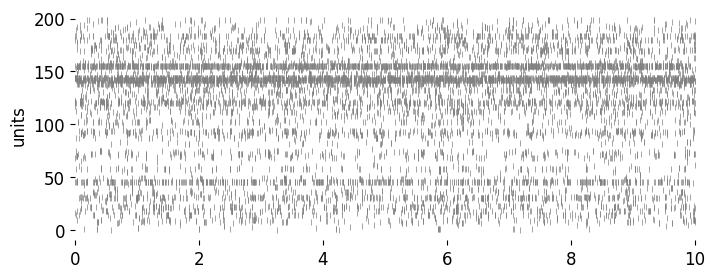

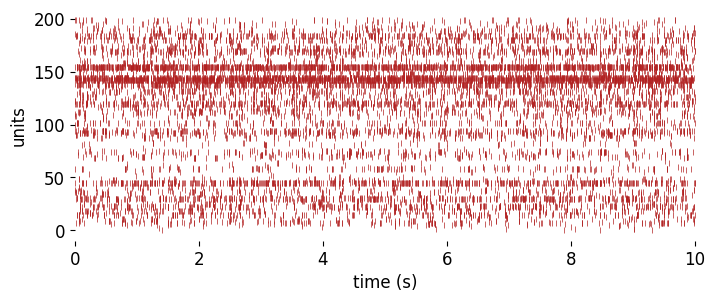

In [ ]:
# Format Spike train plot
def format_spike_trains(results, case_num, trial_num, v_scale, name):
  data = results[case_num][trial_num]
  X = data['X']
  Y = data['Y']
  mean_v_e = data['mean_v_e']
  mean_v_i = data['mean_v_i']

  new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
  plt.rcParams.update(new_rc_params)
  plt.figure(figsize=(8, 3))
  plt.tick_params(axis='y', which='both', labelleft=True, labelright=False)
  for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

  if case_num == 0:
    colour = 'gray'
  else:
    colour = 'firebrick'
    plt.xlabel('time (s)', fontsize=12)

  start = T-10000

  neuron_e, spiketime_e = np.where(X > 0.1)
  plt.plot((spiketime_e - start) / 1000.0, neuron_e, '|', mew = 0.5, markersize=4, color=colour, rasterized=True)

  neuron_i, spiketime_i = np.where(Y > 0.1)
  plt.plot((spiketime_i - start) / 1000.0, neuron_i + N, '|', mew = 0.5, markersize=4, color=colour, rasterized=True)

  plt.xlim(0,10)
  plt.ylabel('units', fontsize=12)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  #plt.title(f"{'Control' if case_num == 0 else 'Cuprizone'}, Trial {trial_num + 1}")
  plt.savefig(name, format='svg', bbox_inches='tight')
  plt.show()

trial_num = 0
format_spike_trains(trial_results, 0, trial_num=trial_num, v_scale=5, name='control_spike_trains.svg')
format_spike_trains(trial_results, 1, trial_num=trial_num, v_scale=20, name='cuprizone_spike_trains.svg')

In [ ]:
def significance_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

#Violin plots
def plot_violinplot(results, title, name):
  FR_all = []

  # KS test
  RS_control = [fr for trial in results[0] for fr in trial['FR_e']]
  RS_cuprizone = [fr for trial in results[1] for fr in trial['FR_e']]
  FS_control = [fr for trial in results[0] for fr in trial['FR_i']]
  FS_cuprizone = [fr for trial in results[1] for fr in trial['FR_i']]

  KS_rs = ks_2samp(RS_control, RS_cuprizone)
  KS_fs = ks_2samp(FS_control, FS_cuprizone)
  RS_star = significance_star(KS_rs.pvalue)
  FS_star = significance_star(KS_fs.pvalue)

  # Data
  for i, group_name in enumerate(['Control', 'Cuprizone']):
    for trial_data in results[i]:
      FR_rs = trial_data['FR_e']
      log_FR_rs = np.log10(FR_rs)
      FR_all.extend([{'Cell Type': 'E', 'Group': group_name, 'FR': fr} for fr in log_FR_rs])

      FR_fs = trial_data['FR_i']
      log_FR_fs = np.log10(FR_fs)
      FR_all.extend([{'Cell Type': 'I', 'Group': group_name, 'FR': fr} for fr in log_FR_fs])

  df = pd.DataFrame(FR_all)

  # Plot
  new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
  plt.rcParams.update(new_rc_params)
  plt.figure(figsize=(8, 5))
  for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)

  sns.violinplot(x='Cell Type', y='FR', data=df, hue='Group', split=False, inner='quart', linewidth=1, palette={"Control": "lightgray", "Cuprizone": "salmon"}, legend = False)
  sns.swarmplot(x='Cell Type', y='FR', data=df, hue='Group', dodge = True, palette={"Control": "gray", "Cuprizone": "red"}, size=2, legend=False)

  #plt.title(title, fontsize=12)
  plt.xlabel("Cell Type", fontsize=12)
  plt.ylabel("Firing Rate (Log Hz)", fontsize=12)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  ax = plt.gca()
  y_max = df['FR'].max()
  ax.text(0, y_max + 0.6, RS_star, ha='center', va='bottom', fontsize=14)
  ax.text(1, y_max + 0.6, FS_star, ha='center', va='bottom', fontsize=14)

  ax.set_ylim(-3, 3)
  ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1f}'))
  #plt.legend(title='Group', loc='lower right')
  plt.tight_layout()
  plt.savefig(name, format='svg', bbox_inches='tight')
  plt.show()


In [ ]:
plot_violinplot(trial_results, "RS and FS cell firing rates", name='cf_violin.svg')

# CV

In [ ]:
# Parameters
dt = 0.1
N = 100 #No. of neurons
T = 120000 #Time
t_IP_on = 0
t_IP_off = 60000
t_myelin_on = t_IP_off + 1000
t_myelin_off = T
time = np.arange(0, T, 1)

beta = 20
epsilon_h = 0.01
h = 1
Ie = 0
Ii = 0
alpha_e = 1
alpha_i = 2
rho = 0.0
D = 0.025
k = 2  # Must remain 2!
theta = 0.05 #4

kappa = 12
p_ee = 0.11
p_ie = 0.29
p_ei = 0.2
p_ii = 0.26
wee, wie, wei, wii = (0.1825 / p_ee * kappa) / N, (-0.2809 / p_ie * kappa) / N, (0.3508 / p_ei * kappa) / N, (-0.2278 / p_ii * kappa) / N #Campagnola weights

@njit
def F(u, h):
    return 0.5 * (1 + math.erf(beta * (u - h)))

@njit(parallel=True)
def simulate_neurons(v_e, v_i, X, Y, W, taue, taui, taue_ref, taui_ref, xie, xii, xi_c, h_e, h_i, r_e, r_i, epsilon_h, t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, Noise_amplitudes, rng_spike):
  mean_v_e = np.zeros(len(time))
  mean_v_i = np.zeros(len(time))
  spike_count_e = np.zeros(N)
  spike_count_i = np.zeros(N)
  FR_e = np.zeros(N)
  FR_i = np.zeros(N)

  for t in range(len(time) - 1):
    for i in range(N):
      sumee, sumie, sumei, sumii = 0.0, 0.0, 0.0, 0.0
      for j in range(N):
        if t>t_myelin_on and t<t_myelin_off:
          delay_e, delay_i = max(0, t - taue[i, j]), max(0, t - taui[i, j])
        else:
          delay_e, delay_i = max(0, t - taue_ref[i, j]), max(0, t - taui_ref[i, j])
        sumee += wee * X[j, delay_e] * W[i, j]
        sumie += wie * Y[j, delay_i] * W[i, j + N]
        sumei += wei * X[j, delay_e] * W[i + N, j]
        sumii += wii * Y[j, delay_i] * W[i + N, j + N]

      v_e[i, t + 1] = v_e[i, t] + dt * alpha_e * (-v_e[i, t] + sumee + sumie + Ie) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xie[i, t]
      v_i[i, t + 1] = v_i[i, t] + dt * alpha_i * (-v_i[i, t] + sumei + sumii + Ii) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xii[i, t]

      # Adaptive thresholds
      if t_IP_on < time[t] < t_IP_off:
        h_e[i, t + 1] = h_e[i, t] + dt * (epsilon_h * (F(v_e[i, t], h_e[i, t]) - r_e[i]))
        h_i[i, t + 1] = h_i[i, t] + dt * (epsilon_h * (F(v_i[i, t], h_i[i, t]) - r_i[i]))
      else:
        h_e[i, t + 1] = h_e[i, t]
        h_i[i, t + 1] = h_i[i, t]

      # Spike thresholds
      if rng_spike.random() < (1 - math.exp(-F(v_e[i, t + 1], h_e[i, t + 1]) * dt)):
        X[i, t + 1] = 1 / dt
        if time[t] > t_myelin_on:
          spike_count_e[i] += 1

      if rng_spike.random() < (1 - math.exp(-F(v_i[i, t + 1], h_i[i, t + 1]) * dt)):
        Y[i, t + 1] = 1 / dt
        if time[t] > t_myelin_on:
          spike_count_i[i] += 1

    mean_v_e[t] = np.mean(v_e[:, t])
    mean_v_i[t] = np.mean(v_i[:, t])

  FR_e = spike_count_e / ((T-t_myelin_on) / 1000)
  FR_i = spike_count_i / ((T-t_myelin_on) / 1000)

  return mean_v_e, mean_v_i, FR_e, FR_i, h_e, h_i

num_trials = 10
cv_e =   [0.5, 0.2] #mm/ms
cv_i =   [0.5, 0.1]

def run_trial(num_trials, cv_e, cv_i, r_e, r_i):
  results = {0: [], 1: []}

  for i, (cve, cvi) in enumerate(zip(cv_e, cv_i)):
    for trial in range(num_trials):

      L = np.random.gamma(k, theta, size=(N, N)) #mean = k * theta
      taue_ref = np.ceil(L / cv_e[0]).astype(int)
      taui_ref = np.ceil(L / cv_i[0]).astype(int) #ms
      taue_gr = np.ceil(L / cv_e[i]).astype(int)
      taui_gr = np.ceil(L / cv_i[i]).astype(int)

      W = np.zeros((2*N, 2*N))
      W[0:N, 0:N] = (np.random.rand(N, N) < p_ee).astype(float) # E → E: (pre: 0:N, post: 0:N)
      W[N:2*N, 0:N] = (np.random.rand(N, N) < p_ei).astype(float) # E → I: (post: N:2N, pre: 0:N)
      W[0:N, N:2*N] = (np.random.rand(N, N) < p_ie).astype(float) # I → E: (post: 0:N, pre: N:2N)
      W[N:2*N, N:2*N] = (np.random.rand(N, N) < p_ii).astype(float) # I → I: (post: N:2N, pre: N:2N)
      np.fill_diagonal(W, 0)

      xie = np.random.normal(0, 1, size=(N, len(time)))
      xii = np.random.normal(0, 1, size=(N, len(time)))
      xi_c = np.random.normal(0, 1, size=len(time))
      Noise_amplitudes = np.mean(np.random.uniform(size=N)) * np.ones(N)

      v_e = np.zeros((N, len(time)))
      v_i = np.zeros((N, len(time)))
      X = np.zeros((N, len(time)))
      Y = np.zeros((N, len(time)))
      h_e = np.ones((N, len(time))) * h
      h_i = np.ones((N, len(time))) * h

      rng_spike = np.random.default_rng(123 + trial)

      mean_v_e, mean_v_i, FR_e, FR_i, h_e_final, h_i_final = simulate_neurons(v_e, v_i, X, Y, W, taue_gr, taui_gr, taue_ref, taui_ref, xie, xii, xi_c, h_e, h_i, r_e, r_i, epsilon_h, t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, Noise_amplitudes,
                                                                              rng_spike)

      results[i].append({'mean_v_e': mean_v_e, 'mean_v_i': mean_v_i,'FR_e': FR_e, 'FR_i': FR_i, 'h_e': h_e_final, 'h_i': h_i_final, 'X': X, 'Y': Y})

  return results

r_e = np.random.lognormal(mean=np.log(4) - (1.5 ** 2) / 2, sigma=1.5, size=N) / 100 #μ + σ**2/2
r_i = np.random.lognormal(mean=np.log(6) - (1.5 ** 2) / 2, sigma=1.5, size=N) / 100

trial_results = run_trial(num_trials, cv_e, cv_i, r_e, r_i)

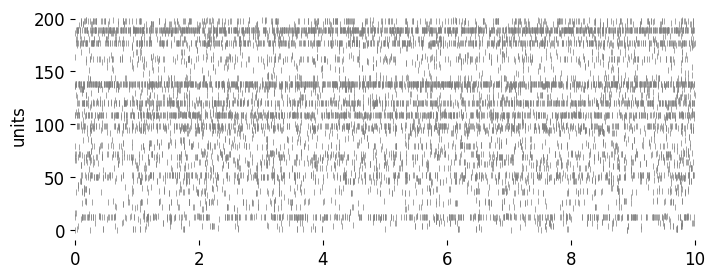

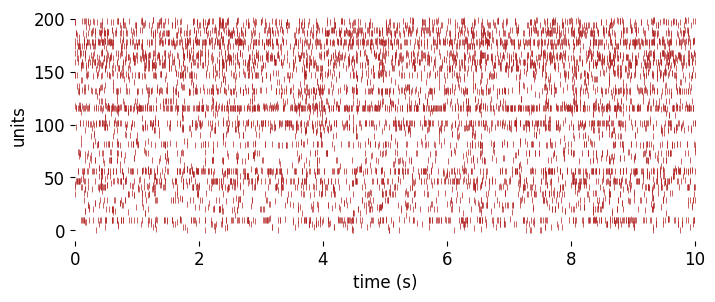

In [ ]:
trial_num = 0
format_spike_trains(trial_results, 0, trial_num=trial_num, v_scale=5, name='cv_spike_trains.svg')
format_spike_trains(trial_results, 1, trial_num=trial_num, v_scale=20, name='cv2_spike_trains.svg')

                           Q1    Median        Q3       IQR   Mean_FR
Cell Type Group                                                      
E         Control   -0.372912  0.112800  0.539837  0.912749  0.146552
          Cuprizone -0.372912  0.107085  0.540902  0.913814  0.140376
I         Control   -0.080656  0.373719  0.652803  0.733459  0.328163
          Cuprizone -0.080656  0.370595  0.665311  0.745967  0.329752


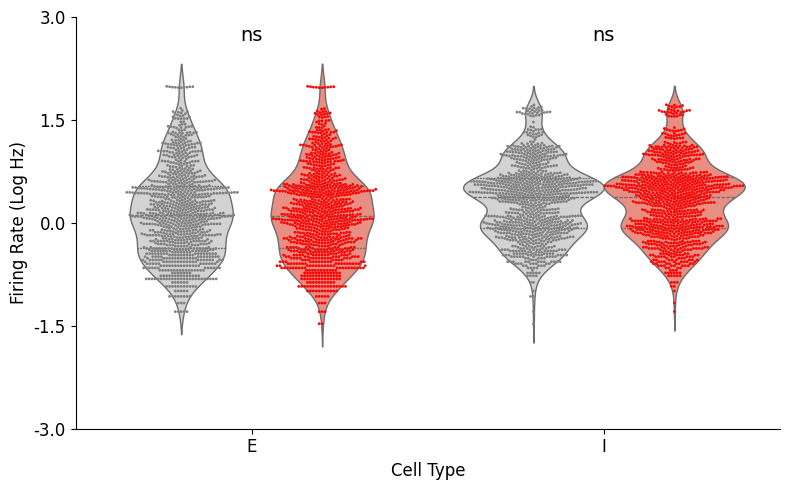

In [ ]:
plot_violinplot(trial_results, "RS and FS cell firing rates", name='cv_violin.svg')

# Loop fe and fi (conduction failure)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import special
from numba import njit, prange
import math
from joblib import Parallel, delayed

# ------------------- PARAMETERS -------------------
dt = 0.1
N = 100
T = 120000
time = np.arange(0, T, 1)
t_IP_on = 0
t_IP_off = 60000
t_myelin_on = t_IP_off + 1000
t_myelin_off = T

beta = 20
epsilon_h = 0.01
h = 1 #reference threshold
Ie = 0.0 #bias E cells  # -0.25+h
Ii = 0.0 #bias I cells # -0.25+h
alpha_e = 1
alpha_i = 2
rho = 0 #Noise spatial correlation
D = 0.025 #Noise amplitude
k = 2  # Must remain 2!
theta = 0.05 #4

ce = 0.5
ci = 0.5

kappa = 12
p_ee = 0.11
p_ie = 0.29
p_ei = 0.2
p_ii = 0.26
wee, wie, wei, wii = (0.1825 / p_ee * kappa) / N, (-0.2809 / p_ie * kappa) / N, (0.3508 / p_ei * kappa) / N, (-0.2278 / p_ii * kappa) / N #Campagnola weights

num_trials = 20

# ------------------- FUNCTIONS -------------------
@njit
def F(u, threshold):
    return 0.5 * (1 + math.erf(beta * (u - threshold)))

@njit(parallel=True)
def simulate_neurons(v_e, v_i, X, Y, X_cond, Y_cond, W, taue, taui, xie, xii, xi_c, h_e, h_i, target_rates_e, target_rates_i,
                     t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, beta, D, rho, fe, fi, Noise_amplitudes, rng_spike, rng_fail):
  mean_v_e = np.zeros(len(time))
  mean_v_i = np.zeros(len(time))
  spike_count_e = np.zeros(N)
  spike_count_i = np.zeros(N)
  FR_e = np.zeros(N)
  FR_i = np.zeros(N)

  for t in range(len(time) - 1):
    for i in range(N):
      sumee, sumie, sumei, sumii = 0.0, 0.0, 0.0, 0.0
      for j in range(N):
        delay_e, delay_i = max(0, t - taue[i, j]), max(0, t - taui[i, j])
        sumee += wee * X_cond[j, delay_e] * W[i, j]
        sumie += wie * Y_cond[j, delay_i] * W[i, j + N]
        sumei += wei * X_cond[j, delay_e] * W[i + N, j]
        sumii += wii * Y_cond[j, delay_i] * W[i + N, j + N]

      v_e[i, t + 1] = v_e[i, t] + dt * alpha_e * (-v_e[i, t] + sumee + sumie + Ie) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xie[i, t]
      v_i[i, t + 1] = v_i[i, t] + dt * alpha_i * (-v_i[i, t] + sumei + sumii + Ii) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xii[i, t]

      # Adaptive threshold
      if time[t]>t_IP_on and time[t]<t_IP_off:
        h_e[i, t + 1] = h_e[i, t] + dt * (epsilon_h * (F(v_e[i, t], h_e[i, t]) - target_rates_e[i]))
        h_i[i, t + 1] = h_i[i, t] + dt * (epsilon_h * (F(v_i[i, t], h_i[i, t]) - target_rates_i[i]))
      else:
        h_e[i, t + 1] = h_e[i, t]
        h_i[i, t + 1] = h_i[i, t]

      #Spike threshold
      if rng_spike.random() < (1 - math.exp(-F(v_e[i, t + 1], h_e[i, t + 1]) * dt)):
        X[i, t + 1] = 1 / dt
        if time[t] > t_myelin_on:
          spike_count_e[i] += 1
          if rng_fail.random() > fe:
            X_cond[i, t + 1] = 1 / dt
          else:
            X_cond[i, t + 1] = 0
        else:
          X_cond[i, t + 1] = 1 / dt

      if rng_spike.random() < (1 - math.exp(-F(v_i[i, t + 1], h_i[i, t + 1]) * dt)):
        Y[i, t + 1] = 1 / dt
        if time[t] > t_myelin_on:
          spike_count_i[i] += 1
          if rng_fail.random() > fi:
            Y_cond[i, t + 1] = 1 / dt
          else:
            Y_cond[i, t + 1] = 0
        else:
          Y_cond[i, t + 1] = 1 / dt

    mean_v_e[t] = np.mean(v_e[:, t])
    mean_v_i[t] = np.mean(v_i[:, t])

  FR_e = spike_count_e / ((T-t_myelin_on) / 1000)
  FR_i = spike_count_i / ((T-t_myelin_on) / 1000)

  return mean_v_e, mean_v_i, FR_e, FR_i, h_e, h_i

def run_trial(fe, fi, trial, time, N, num_trials, target_rates_e, target_rates_i):
    print(f"Processing fe={fe:.2f}, fi={fi:.2f}")
    L = np.random.gamma(k, theta, size=(N, N))
    taue = np.ceil(L / ce).astype(int)
    taui = np.ceil(L / ci).astype(int)

    W = np.zeros((2*N, 2*N))
    W[0:N, 0:N] = (np.random.rand(N, N) < p_ee).astype(float) # E → E: (pre: 0:N, post: 0:N)
    W[N:2*N, 0:N] = (np.random.rand(N, N) < p_ei).astype(float) # E → I: (post: N:2N, pre: 0:N)
    W[0:N, N:2*N] = (np.random.rand(N, N) < p_ie).astype(float) # I → E: (post: 0:N, pre: N:2N)
    W[N:2*N, N:2*N] = (np.random.rand(N, N) < p_ii).astype(float) # I → I: (post: N:2N, pre: N:2N)
    np.fill_diagonal(W, 0)

    v_e = np.zeros((N, len(time)))
    v_i = np.zeros((N, len(time)))
    X = np.zeros((N, len(time)))
    Y = np.zeros((N, len(time)))
    X_cond, Y_cond = np.zeros((N, len(time))), np.zeros((N, len(time)))
    xie = np.random.normal(0, 1, size=(N, len(time)))
    xii = np.random.normal(0, 1, size=(N, len(time)))
    xi_c = np.random.normal(0, 1, size=len(time))
    Noise_amplitudes = np.mean(np.random.uniform(size=N)) * np.ones(N)
    h_e, h_i = np.ones((N, len(time))) * h, np.ones((N, len(time))) * h
    rng_spike = np.random.default_rng(123)
    rng_fail = np.random.default_rng(456)

    mean_v_e, mean_v_i, FR_e, FR_i, H_e, H_i = simulate_neurons(
        v_e, v_i, X, Y, X_cond, Y_cond, W, taue, taui, xie, xii, xi_c, h_e, h_i, target_rates_e, target_rates_i,
        t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, beta, D, rho, fe, fi, Noise_amplitudes, rng_spike, rng_fail)

    # Correlation
    t_myelin_onn = int(t_myelin_on)
    X_bin = X[:, t_myelin_onn:] > 0
    Y_bin = Y[:, t_myelin_onn:] > 0

    # Filter out neurons with all zeros (no spikes)
    nonzero_e = np.any(X_bin, axis=1)
    nonzero_i = np.any(Y_bin, axis=1)
    X_bin = X_bin[nonzero_e]
    Y_bin = Y_bin[nonzero_i]

    # Proceed only if there are at least two neurons with activity
    if X_bin.shape[0] + Y_bin.shape[0] >= 2:
        all_bin = np.vstack([X_bin, Y_bin])
        corr_matrix_a = np.corrcoef(all_bin)
        upper_tri_indices_a = np.triu_indices_from(corr_matrix_a, k=1)
        pairwise_corrs_a = corr_matrix_a[upper_tri_indices_a]
        mean_spike_corr_a = np.nanmean(pairwise_corrs_a)

        # E-E
        if X_bin.shape[0] >= 2:
            corr_matrix = np.corrcoef(X_bin)
            upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
            pairwise_corrs = corr_matrix[upper_tri_indices]
            mean_spike_corr_ee = np.nanmean(pairwise_corrs)
        else:
            mean_spike_corr_ee = np.nan

        # E-I
        if X_bin.shape[0] > 0 and Y_bin.shape[0] > 0:
            mean_spike_corr_ei = np.nanmean([
                np.corrcoef(X_bin[i], Y_bin[j])[0, 1]
                for i in range(X_bin.shape[0])
                for j in range(Y_bin.shape[0])
                if np.std(X_bin[i]) > 0 and np.std(Y_bin[j]) > 0
            ])
        else:
            mean_spike_corr_ei = np.nan
    else:
        mean_spike_corr_a = np.nan
        mean_spike_corr_ee = np.nan
        mean_spike_corr_ei = np.nan

    var_a = np.var((mean_v_e + mean_v_i) / 2)

    return fe, fi, mean_spike_corr_a, mean_spike_corr_ee, mean_spike_corr_ei, var_a, np.mean(FR_e), np.mean(FR_i), mean_v_e, mean_v_i

# ------------------- INITIALIZATION -------------------
fe_values = np.linspace(0, 0.1, 5)
fi_values = np.linspace(0, 0.3, 5)

target_rates_e = np.random.lognormal(mean=np.log(4) - (1.5 ** 2) / 2, sigma=1.5, size=N)/100
target_rates_i = np.random.lognormal(mean=np.log(6) - (1.5 ** 2) / 2, sigma=1.5, size=N)/100
FR_e_map = np.zeros((len(fe_values), len(fi_values)))
FR_i_map = np.zeros((len(fe_values), len(fi_values)))
var_a_map = np.zeros((len(fe_values), len(fi_values)))
mean_spike_corr_a_map = np.zeros((len(fe_values), len(fi_values)))
mean_spike_corr_ee_map = np.zeros((len(fe_values), len(fi_values)))
mean_spike_corr_ei_map = np.zeros((len(fe_values), len(fi_values)))

ve_trials = []
vi_trials = []

results = Parallel(n_jobs=-1)(
    delayed(run_trial)(fe, fi, trial, time, N, num_trials, target_rates_e, target_rates_i)
    for fe in fe_values
    for fi in fi_values
    for trial in range(num_trials)
)

for i, fe in enumerate(fe_values):
    for j, fi in enumerate(fi_values):
        trial_results = [result for result in results if result[0] == fe and result[1] == fi]
        mean_spike_corr_a_map[i, j] = np.mean([r[2] for r in trial_results])
        mean_spike_corr_ee_map[i, j] = np.mean([r[3] for r in trial_results])
        mean_spike_corr_ei_map[i, j] = np.mean([r[4] for r in trial_results])
        var_a_map[i, j] = np.mean([r[5] for r in trial_results])
        FR_e_map[i, j] = np.mean([r[6] for r in trial_results])
        FR_i_map[i, j] = np.mean([r[7] for r in trial_results])

        for r in trial_results:
            ve_trials.append(r[8])
            vi_trials.append(r[9])

In [ ]:
#@title Figue heatmaps
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches

new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

# Create subplots for the maps
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot Variance of ALL
#var_a_control = var_a_map[0,0]
#norm_var_a = (var_a_map - var_a_control) / var_a_control
#min2 = np.min(norm_var_a) * 0.95
#max2 = np.max(norm_var_a) * 1.05
#cax2 = axs[1].imshow(norm_var_a, aspect='auto', cmap="YlGnBu", interpolation="nearest", vmin=min2, vmax=max2)
#axs[1].set_title("Membrane Potential Variance", fontsize=18)
#axs[1].set_xlabel("inhibitory failure rate (%)", fontsize=18)
#axs[1].set_ylabel("excitatory failure rate (%)", fontsize=18)
#axs[1].set_xticks(np.arange(len(fi_values)))
#axs[1].set_yticks(np.arange(len(fe_values)))
#axs[1].set_xticklabels(np.round(fi_values, 2), fontsize=14)
#axs[1].set_yticklabels(np.round(fe_values, 2), fontsize=14)
#axs[1].invert_yaxis()
#colorbar = fig.colorbar(cax2, ax=axs[1], orientation='vertical')
#colorbar.locator = MaxNLocator(nbins=6)
#colorbar.update_ticks()
#colorbar.ax.tick_params(labelsize=14)

# Firing rate RS
FR_e_control = FR_e_map[0, 0]
norm_FR_e = (FR_e_map - FR_e_control) / FR_e_control *100
FR_i_control = FR_i_map[0, 0]
norm_FR_i = (FR_i_map - FR_i_control) / FR_i_control *100
min3 = np.floor(min(np.min(norm_FR_e), np.min(norm_FR_i)))
max3 = np.ceil(max(np.max(norm_FR_e), np.max(norm_FR_i)))

cax3 = axs[0].imshow(norm_FR_e, cmap="plasma", aspect='auto', interpolation="nearest", vmin=min3, vmax=100)
axs[0].set_title("% Change in Mean E-Cell Firing Rate", fontsize=14)
axs[0].set_xlabel("inhibitory failure rate (%)", fontsize=14)
axs[0].set_ylabel("excitatory failure rate (%)", fontsize=14)
axs[0].set_xticks(np.arange(len(fi_values)))
axs[0].set_yticks(np.arange(len(fe_values)))
axs[0].set_xticklabels(np.round(fi_values*100, 1), fontsize=14)
axs[0].set_yticklabels(np.round(fe_values*100, 1), fontsize=14)
axs[0].invert_yaxis()

#axs[0].add_patch(patches.Rectangle((0-0.48, 0-0.48), 0.95, 0.97, fill=False, edgecolor='lightgrey', lw=2))
#axs[0].add_patch(patches.Rectangle((4-0.5, 4-0.5), 0.97, 0.98, fill=False, edgecolor='firebrick', lw=2))

colorbar = fig.colorbar(cax3, ax=axs[0], orientation='vertical')
#colorbar.set_label('% change from control', fontsize=12)
colorbar.set_ticks(np.linspace(min3, max3, 5))
colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)


# Firing rate FS
cax3 = axs[1].imshow(norm_FR_i, cmap="plasma", aspect='auto', interpolation="nearest", vmin=min3, vmax=100)
axs[1].set_title("% Change in Mean I-Cell Firing Rate", fontsize=14)
axs[1].set_xlabel("inhibitory failure rate (%)", fontsize=14)
axs[1].set_ylabel("excitatory failure rate (%)", fontsize=14)
axs[1].set_xticks(np.arange(len(fi_values)))
axs[1].set_yticks(np.arange(len(fe_values)))
axs[1].set_xticklabels(np.round(fi_values*100, 1), fontsize=14)
axs[1].set_yticklabels(np.round(fe_values*100, 1), fontsize=14)
axs[1].invert_yaxis()

axs[1].add_patch(patches.Rectangle((0-0.48, 0-0.48), 0.96, 0.97, fill=False, edgecolor='lightgrey', lw=2))
axs[1].add_patch(patches.Rectangle((4-0.5, 4-0.5), 0.97, 0.98, fill=False, edgecolor='firebrick', lw=2))

colorbar = fig.colorbar(cax3, ax=axs[1], orientation='vertical')
#colorbar.set_label('% change from control', fontsize=12)
colorbar.set_ticks(np.linspace(min3, max3, 5))
colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)

# Plot Mean Pairwise Correlation ALL
corr_a_control = mean_spike_corr_a_map[0,0]
norm_corr_a = (mean_spike_corr_a_map - corr_a_control) / corr_a_control *100
min1 = np.floor(np.min(norm_corr_a))
max1 = np.ceil(np.max(norm_corr_a))
cax1 = axs[2].imshow(norm_corr_a, aspect='auto', cmap="viridis", interpolation="nearest", vmin=min1, vmax=max1)
axs[2].set_title("% Change in Mean Pairwise Correlation", fontsize=14)
axs[2].set_xlabel("inhibitory failure rate (%)", fontsize=14)
axs[2].set_ylabel("excitatory failure rate (%)", fontsize=14)
axs[2].set_xticks(np.arange(len(fi_values)))
axs[2].set_yticks(np.arange(len(fe_values)))
axs[2].set_xticklabels(np.round(fi_values*100, 1), fontsize=14)
axs[2].set_yticklabels(np.round(fe_values*100, 1), fontsize=14)
axs[2].invert_yaxis()

axs[2].add_patch(patches.Rectangle((0-0.48, 0-0.48), 0.96, 0.97, fill=False, edgecolor='lightgrey', lw=2))
axs[2].add_patch(patches.Rectangle((4-0.5, 4-0.5), 0.97, 0.98, fill=False, edgecolor='firebrick', lw=2))

colorbar = fig.colorbar(cax1, ax=axs[2], orientation='vertical')
#colorbar.set_label('% change from control', fontsize=12)
colorbar.set_ticks(np.linspace(min1, max1, 6))
colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent overlap
#plt.subplots_adjust(right=0.2)
plt.tight_layout()

# Show the plots
plt.savefig('cf_heatmaps.svg', format='svg')
plt.show()

# Loop CVe and CVi (conduction velocity)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import special
from numba import njit, prange
import math
from joblib import Parallel, delayed

# ------------------- PARAMETERS -------------------
dt = 0.1
N = 100
T = 120000
time = np.arange(0, T, 1)
t_IP_on = 0
t_IP_off = 60000
t_myelin_on= t_IP_off+1000
t_myelin_off = T

beta = 20
epsilon_h = 0.01
h = 1 #reference threshold
Ie = 0 #bias E cells  # -0.25+h
Ii = 0 #bias I cells # -0.25+h
rho = 0 #Noise spatial correlation
D = 0.025 #Noise amplitude
k = 2  # Must remain 2!
theta = 0.05 #4
alpha_e = 1
alpha_i = 2

kappa = 12
p_ee = 0.11
p_ie = 0.29
p_ei = 0.2
p_ii = 0.26
wee, wie, wei, wii = (0.1825 / p_ee * kappa) / N, (-0.2809 / p_ie * kappa) / N, (0.3508 / p_ei * kappa) / N, (-0.2278 / p_ii * kappa) / N #Campagnola weights

num_trials = 10

# ------------------- FUNCTIONS -------------------
@njit
def F(u, threshold):
    return 0.5 * (1 + math.erf(beta * (u - threshold)))

@njit(parallel=True)
def simulate_neurons(v_e, v_i, X, Y, W, taue, taui, taue_ref, taui_ref, xie, xii, xi_c, h_e, h_i, target_rates_e, target_rates_i,
                     t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, beta, D, rho, Noise_amplitudes, rng_spike):
    mean_v_e = np.zeros(len(time))
    mean_v_i = np.zeros(len(time))
    spike_count_e = np.zeros(N)
    spike_count_i = np.zeros(N)
    FR_e = np.zeros(N)
    FR_i = np.zeros(N)

    for t in range(len(time) - 1):
        for i in range(N):
            sumee, sumie, sumei, sumii = 0.0, 0.0, 0.0, 0.0
            for j in range(N):
              if t>t_myelin_on and t<t_myelin_off:
                delay_e, delay_i = max(0, t - taue[i, j]), max(0, t - taui[i, j])
              else:
                delay_e, delay_i = max(0, t - taue_ref[i, j]), max(0, t - taui_ref[i, j])
              sumee += wee * X[j, delay_e] * W[i, j]
              sumie += wie * Y[j, delay_i] * W[i, j + N]
              sumei += wei * X[j, delay_e] * W[i + N, j]
              sumii += wii * Y[j, delay_i] * W[i + N, j + N]

            v_e[i, t + 1] = v_e[i, t] + dt * alpha_e * (-v_e[i, t] + sumee + sumie + Ie) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xie[i, t]
            v_i[i, t + 1] = v_i[i, t] + dt * alpha_i * (-v_i[i, t] + sumei + sumii + Ii) + math.sqrt(2 * D * Noise_amplitudes[i] * rho) * xi_c[t] + math.sqrt(2 * D * Noise_amplitudes[i] * (1 - rho)) * xii[i, t]

            # Adaptive threshold
            if time[t]>t_IP_on and time[t]<t_IP_off:
              h_e[i, t + 1] = h_e[i, t] + dt * (epsilon_h * (F(v_e[i, t], h_e[i, t]) - target_rates_e[i]))
              h_i[i, t + 1] = h_i[i, t] + dt * (epsilon_h * (F(v_i[i, t], h_i[i, t]) - target_rates_i[i]))
            else:
              h_e[i, t + 1] = h_e[i, t]
              h_i[i, t + 1] = h_i[i, t]

            #Spike threshold
            if rng_spike.random() < (1 - math.exp(-F(v_e[i, t + 1], h_e[i, t + 1]) * dt)):
                X[i, t + 1] = 1 / dt
                if time[t] > t_myelin_on:
                    spike_count_e[i] += 1

            if rng_spike.random() < (1 - math.exp(-F(v_i[i, t + 1], h_i[i, t + 1]) * dt)):
                Y[i, t + 1] = 1 / dt
                if time[t] > t_myelin_on:
                    spike_count_i[i] += 1

        mean_v_e[t] = np.mean(v_e[:, t])
        mean_v_i[t] = np.mean(v_i[:, t])

    FR_e = spike_count_e / ((T-t_myelin_on) / 1000)
    FR_i = spike_count_i / ((T-t_myelin_on) / 1000)

    return mean_v_e, mean_v_i, FR_e, FR_i, h_e, h_i

def run_trial(ce, ci, trial, time, N, num_trials, target_rates_e, target_rates_i):
    print(f"Processing ce={ce:.2f}, ci={ci:.2f}")
    L = np.random.gamma(k, theta, size=(N, N))
    taue = np.ceil(L / ce).astype(int)
    taui = np.ceil(L / ci).astype(int)
    taue_ref = np.ceil(L / 1).astype(int)
    taui_ref = np.ceil(L / 1).astype(int)

    W = np.zeros((2*N, 2*N))
    W[0:N, 0:N] = (np.random.rand(N, N) < p_ee).astype(float) # E → E: (pre: 0:N, post: 0:N)
    W[N:2*N, 0:N] = (np.random.rand(N, N) < p_ei).astype(float) # E → I: (post: N:2N, pre: 0:N)
    W[0:N, N:2*N] = (np.random.rand(N, N) < p_ie).astype(float) # I → E: (post: 0:N, pre: N:2N)
    W[N:2*N, N:2*N] = (np.random.rand(N, N) < p_ii).astype(float) # I → I: (post: N:2N, pre: N:2N)
    np.fill_diagonal(W, 0)

    v_e = np.zeros((N, len(time)))
    v_i = np.zeros((N, len(time)))
    X = np.zeros((N, len(time)))
    Y = np.zeros((N, len(time)))
    xie = np.random.normal(0, 1, size=(N, len(time)))
    xii = np.random.normal(0, 1, size=(N, len(time)))
    xi_c = np.random.normal(0, 1, size=len(time))
    Noise_amplitudes = np.mean(np.random.uniform(size=N)) * np.ones(N)
    h_e, h_i = np.ones((N, len(time))) * 0.5, np.ones((N, len(time))) * 0.5
    rng_spike = np.random.default_rng(123)

    mean_v_e, mean_v_i, FR_e, FR_i, H_e, H_i = simulate_neurons(
        v_e, v_i, X, Y, W, taue, taui, taue_ref, taui_ref,
        xie, xii, xi_c, h_e, h_i, target_rates_e, target_rates_i,
        t_IP_on, t_IP_off, t_myelin_on, t_myelin_off, beta, D, rho, Noise_amplitudes, rng_spike)

    # Correlation
    t_myelin_onn = int(t_myelin_on)
    X_bin = X[:, t_myelin_onn:] > 0
    Y_bin = Y[:, t_myelin_onn:] > 0

    # Filter out neurons with all zeros (no spikes)
    nonzero_e = np.any(X_bin, axis=1)
    nonzero_i = np.any(Y_bin, axis=1)

    X_bin = X_bin[nonzero_e]
    Y_bin = Y_bin[nonzero_i]

    # Proceed only if there are at least two neurons with activity
    if X_bin.shape[0] + Y_bin.shape[0] >= 2:
        all_bin = np.vstack([X_bin, Y_bin])
        corr_matrix_a = np.corrcoef(all_bin)
        upper_tri_indices_a = np.triu_indices_from(corr_matrix_a, k=1)
        pairwise_corrs_a = corr_matrix_a[upper_tri_indices_a]
        mean_spike_corr_a = np.nanmean(pairwise_corrs_a)

        # E-E
        if X_bin.shape[0] >= 2:
            corr_matrix = np.corrcoef(X_bin)
            upper_tri_indices = np.triu_indices_from(corr_matrix, k=1)
            pairwise_corrs = corr_matrix[upper_tri_indices]
            mean_spike_corr_ee = np.nanmean(pairwise_corrs)
        else:
            mean_spike_corr_ee = np.nan

        # E-I
        if X_bin.shape[0] > 0 and Y_bin.shape[0] > 0:
            mean_spike_corr_ei = np.nanmean([
                np.corrcoef(X_bin[i], Y_bin[j])[0, 1]
                for i in range(X_bin.shape[0])
                for j in range(Y_bin.shape[0])
                if np.std(X_bin[i]) > 0 and np.std(Y_bin[j]) > 0
            ])
        else:
            mean_spike_corr_ei = np.nan
    else:
        mean_spike_corr_a = np.nan
        mean_spike_corr_ee = np.nan
        mean_spike_corr_ei = np.nan

    var_a = np.var((mean_v_e + mean_v_i) / 2)

    return ce, ci, mean_spike_corr_a, mean_spike_corr_ee, mean_spike_corr_ei, var_a, np.mean(FR_e), np.mean(FR_i), mean_v_e, mean_v_i, taue, taui

# ------------------- INITIALIZATION -------------------
ce_values = np.linspace(0.2,0.5,5)
ci_values = np.linspace(0.1,0.5,5)

target_rates_e = np.random.lognormal(mean=np.log(4) - (1.5 ** 2) / 2, sigma=1.5, size=N)/100
target_rates_i = np.random.lognormal(mean=np.log(6) - (1.5 ** 2) / 2, sigma=1.5, size=N)/100
FR_e_map = np.zeros((len(ce_values), len(ci_values)))
FR_i_map = np.zeros((len(ce_values), len(ci_values)))
var_a_map = np.zeros((len(ce_values), len(ci_values)))
mean_spike_corr_a_map = np.zeros((len(ce_values), len(ci_values)))
mean_spike_corr_ee_map = np.zeros((len(ce_values), len(ci_values)))
mean_spike_corr_ei_map = np.zeros((len(ce_values), len(ci_values)))
mean_taue_map = np.zeros((len(ce_values), len(ci_values)))
mean_taui_map = np.zeros((len(ce_values), len(ci_values)))

ve_trials = []
vi_trials = []

results = Parallel(n_jobs=-1)(
    delayed(run_trial)(ce, ci, trial, time, N, num_trials, target_rates_e, target_rates_i)
    for ce in ce_values
    for ci in ci_values
    for trial in range(num_trials)
)

for i, ce in enumerate(ce_values):
    for j, ci in enumerate(ci_values):
        trial_results = [result for result in results if result[0] == ce and result[1] == ci]
        mean_spike_corr_a_map[i, j] = np.mean([r[2] for r in trial_results])
        mean_spike_corr_ee_map[i, j] = np.mean([r[3] for r in trial_results])
        mean_spike_corr_ei_map[i, j] = np.mean([r[4] for r in trial_results])
        var_a_map[i, j] = np.mean([r[5] for r in trial_results])
        FR_e_map[i, j] = np.mean([r[6] for r in trial_results])
        FR_i_map[i, j] = np.mean([r[7] for r in trial_results])
        mean_taue_map[i, j] = np.mean([r[10] for r in trial_results])
        mean_taui_map[i, j] = np.mean([r[11] for r in trial_results])

        for r in trial_results:
            ve_trials.append(r[8])
            vi_trials.append(r[9])

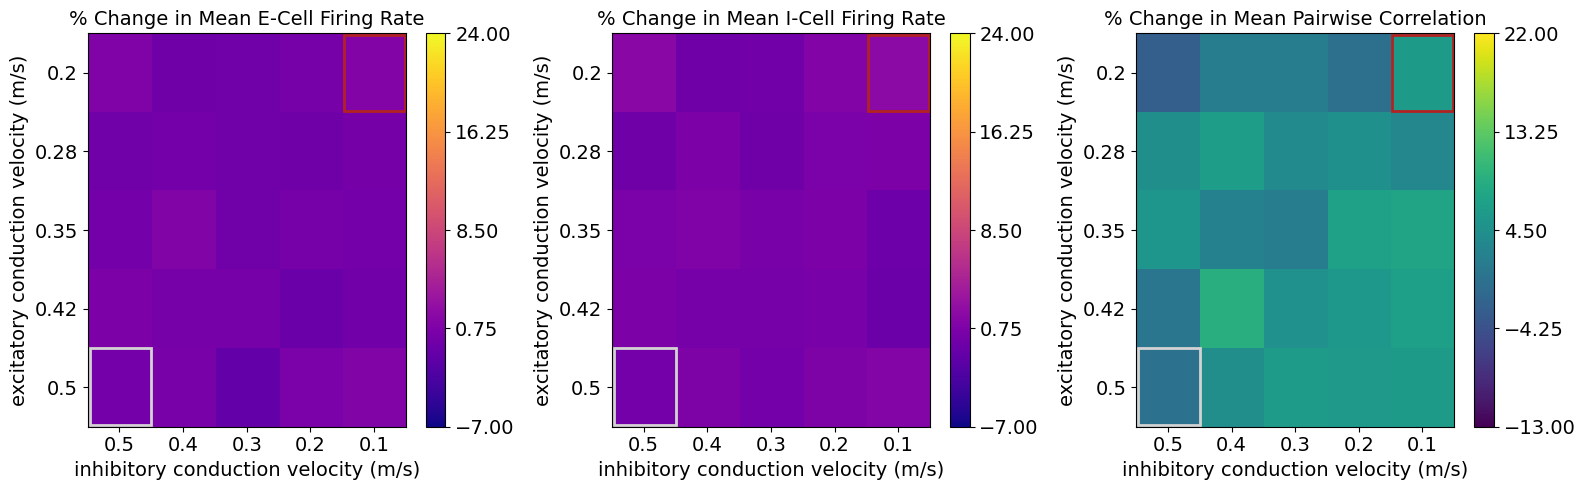

In [ ]:
#@title Figue heatmaps
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

# Create subplots for the maps
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Firing rate RS
FR_e_control = FR_e_map[4,4]
norm_FR_e = (FR_e_map - FR_e_control) / FR_e_control *100
FR_i_control = FR_i_map[4,4]
norm_FR_i = (FR_i_map - FR_i_control) / FR_i_control *100

cax3 = axs[0].imshow(norm_FR_e, cmap="plasma", aspect='auto', interpolation="nearest", vmin=min3, vmax=max3)
axs[0].set_title("% Change in Mean E-Cell Firing Rate", fontsize=14)
axs[0].set_xlabel("inhibitory conduction velocity (m/s)", fontsize=14)
axs[0].set_ylabel("excitatory conduction velocity (m/s)", fontsize=14)
axs[0].set_xticks(np.arange(len(ci_values)))
axs[0].set_yticks(np.arange(len(ce_values)))
axs[0].set_xticklabels(np.round(ci_values, 2), fontsize=14)
axs[0].set_yticklabels(np.round(ce_values, 2), fontsize=14)
axs[0].invert_xaxis()

axs[0].add_patch(patches.Rectangle((0-0.48, 0-0.48), 0.96, 0.97, fill=False, edgecolor='firebrick', lw=2))
axs[0].add_patch(patches.Rectangle((4-0.5, 4-0.5), 0.97, 0.98, fill=False, edgecolor='lightgrey', lw=2))

colorbar = fig.colorbar(cax3, ax=axs[0], orientation='vertical')
colorbar.set_ticks(np.linspace(min3, max3, 5))
colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)

# Firing rate FS
cax3 = axs[1].imshow(norm_FR_i, cmap="plasma", aspect='auto', interpolation="nearest", vmin=min3, vmax=max3)
axs[1].set_title("% Change in Mean I-Cell Firing Rate", fontsize=14)
axs[1].set_xlabel("inhibitory conduction velocity (m/s)", fontsize=14)
axs[1].set_ylabel("excitatory conduction velocity (m/s)", fontsize=14)
axs[1].set_xticks(np.arange(len(ci_values)))
axs[1].set_yticks(np.arange(len(ce_values)))
axs[1].set_xticklabels(np.round(ci_values, 2), fontsize=14)
axs[1].set_yticklabels(np.round(ce_values, 2), fontsize=14)
axs[1].invert_xaxis()

axs[1].add_patch(patches.Rectangle((0-0.48, 0-0.48), 0.96, 0.97, fill=False, edgecolor='firebrick', lw=2))
axs[1].add_patch(patches.Rectangle((4-0.5, 4-0.5), 0.97, 0.98, fill=False, edgecolor='lightgray', lw=2))

colorbar = fig.colorbar(cax3, ax=axs[1], orientation='vertical')
#colorbar.locator = MaxNLocator(nbins=6)
colorbar.set_ticks(np.linspace(min3, max3, 5))
colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)

# Plot Mean Pairwise Correlation ALL
corr_a_control = mean_spike_corr_a_map[4,4]
norm_corr_a = (mean_spike_corr_a_map - corr_a_control) / corr_a_control *100
cax1 = axs[2].imshow(norm_corr_a, aspect='auto', cmap="viridis", interpolation="nearest", vmin=min1, vmax=max1)
axs[2].set_title("% Change in Mean Pairwise Correlation", fontsize=14)
axs[2].set_xlabel("inhibitory conduction velocity (m/s)", fontsize=14)
axs[2].set_ylabel("excitatory conduction velocity (m/s)", fontsize=14)
axs[2].set_xticks(np.arange(len(ci_values)))
axs[2].set_yticks(np.arange(len(ce_values)))
axs[2].set_xticklabels(np.round(ci_values, 2), fontsize=14)
axs[2].set_yticklabels(np.round(ce_values, 2), fontsize=14)
axs[2].invert_xaxis()

axs[2].add_patch(patches.Rectangle((0-0.48, 0-0.48), 0.96, 0.97, fill=False, edgecolor='firebrick', lw=2))
axs[2].add_patch(patches.Rectangle((4-0.5, 4-0.5), 0.97, 0.98, fill=False, edgecolor='lightgray', lw=2))

colorbar = fig.colorbar(cax1, ax=axs[2], orientation='vertical')
colorbar.locator = MaxNLocator(nbins=6)
colorbar.set_ticks(np.linspace(min1, max1, 5))
colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.savefig('cv_heatmaps.svg', format='svg')
plt.show()

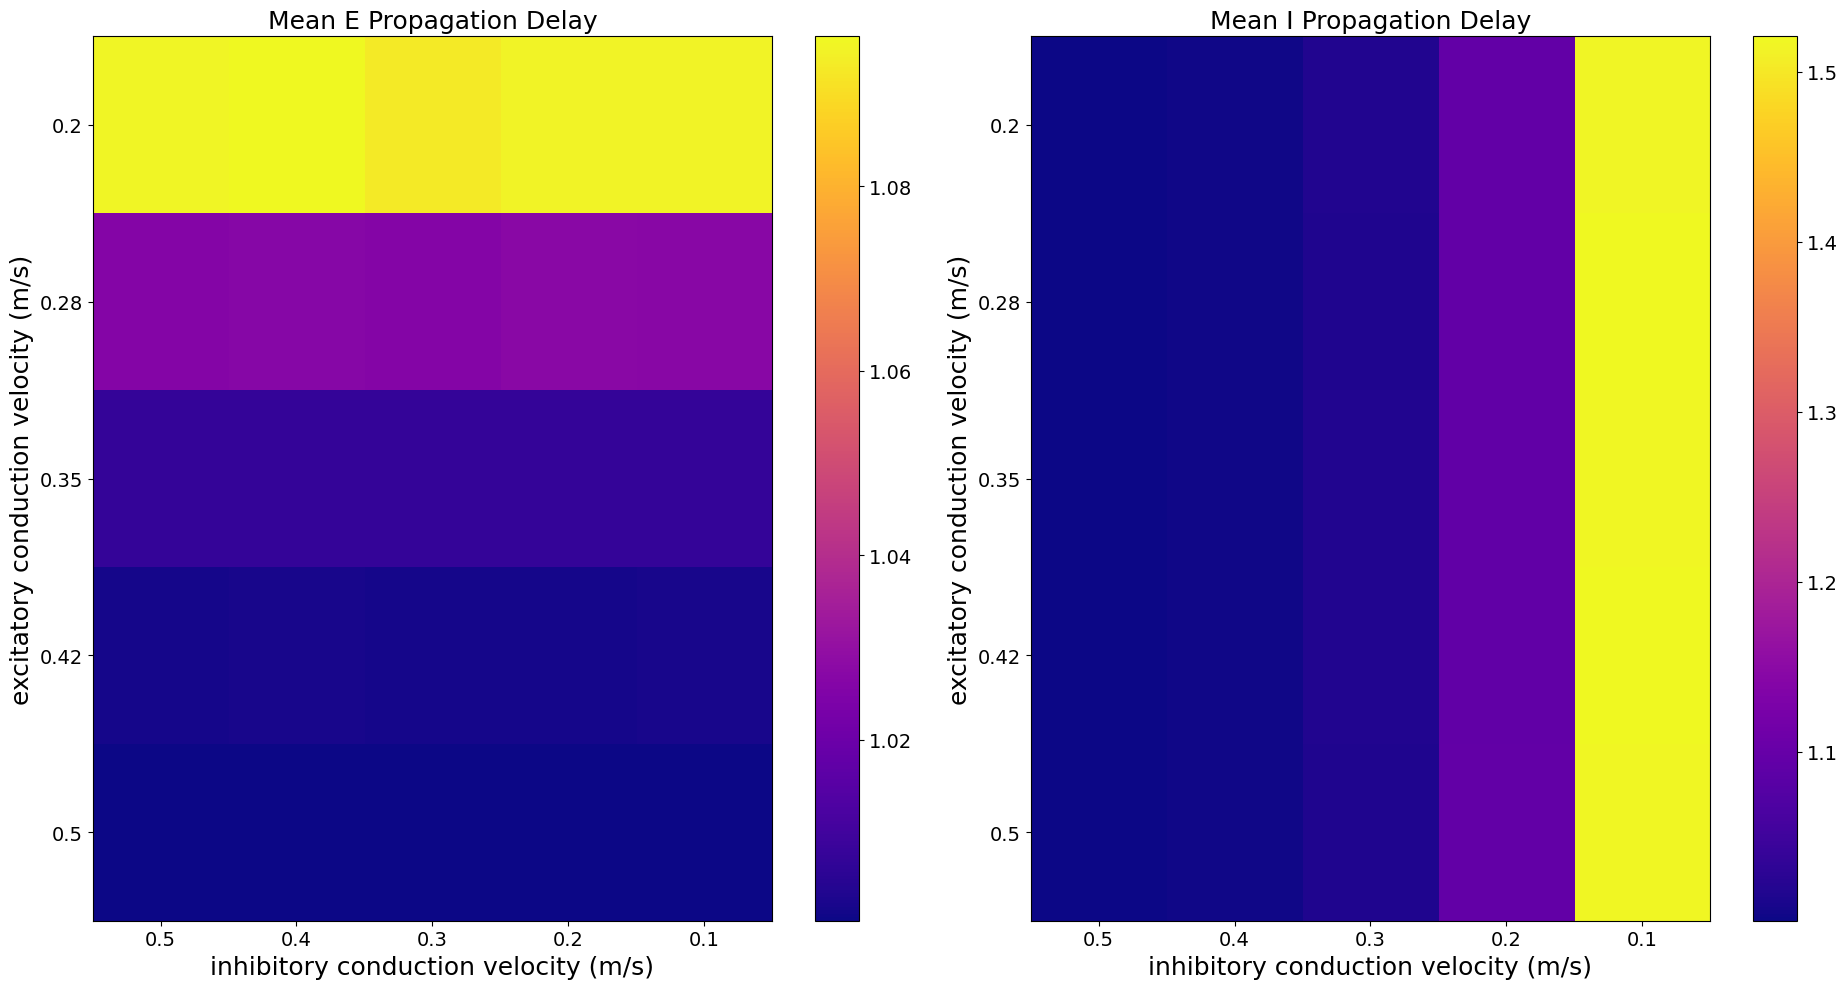

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
# Create subplots for the maps
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

# Plot Mean taue
cax4 = axs[0].imshow(mean_taue_map, aspect='auto', cmap="plasma", interpolation="nearest")
axs[0].set_title("Mean E Propagation Delay", fontsize=18)
axs[0].set_xlabel("inhibitory conduction velocity (m/s)", fontsize=18)
axs[0].set_ylabel("excitatory conduction velocity (m/s)", fontsize=18)
axs[0].set_xticks(np.arange(len(ci_values)))
axs[0].set_yticks(np.arange(len(ce_values)))
axs[0].set_xticklabels(np.round(ci_values, 2), fontsize=14)
axs[0].set_yticklabels(np.round(ce_values, 2), fontsize=14)
axs[0].invert_xaxis()

colorbar = fig.colorbar(cax4, ax=axs[0], orientation='vertical')
colorbar.ax.tick_params(labelsize=14)

# Plot Mean taui
cax4 = axs[1].imshow(mean_taui_map, aspect='auto', cmap="plasma", interpolation="nearest")
axs[1].set_title("Mean I Propagation Delay", fontsize=18)
axs[1].set_xlabel("inhibitory conduction velocity (m/s)", fontsize=18)
axs[1].set_ylabel("excitatory conduction velocity (m/s)", fontsize=18)
axs[1].set_xticks(np.arange(len(ci_values)))
axs[1].set_yticks(np.arange(len(ce_values)))
axs[1].set_xticklabels(np.round(ci_values, 2), fontsize=14)
axs[1].set_yticklabels(np.round(ce_values, 2), fontsize=14)
axs[1].invert_xaxis()

colorbar = fig.colorbar(cax4, ax=axs[1], orientation='vertical')
#colorbar.locator = MaxNLocator(nbins=7)
#colorbar.set_ticks(np.linspace(min1, max1, 5))
#colorbar.update_ticks()
colorbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots
plt.show()